# TDLog : Machine Learning 

# Preparations

In [1]:
# Some imports
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pathlib
from torch.utils.data import sampler, ConcatDataset
import torchaudio.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F
import numpy as np
import copy
import librosa
import librosa.display

In [2]:
#To have access to drive files
try:
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)

  FOLDERNAME = 'TDLog'
  %cd /content/gdrive/My\ Drive/$FOLDERNAME
except ImportError:
  pass

Mounted at /content/gdrive
/content/gdrive/My Drive/TDLog


In [3]:
# Using GPU
USE_GPU = True
dtype = torch.float32 # we will be using float throughout this tutorial
device = torch.device('cuda') if (USE_GPU and torch.cuda.is_available()) else torch.device('cpu')

print('using device:', device)

using device: cuda


In [4]:
# Loading database 
gtzan = dset.GTZAN('Dataset', download=True)

gtzan_train = dset.GTZAN('Dataset', subset='training', download=True)

gtzan_val = dset.GTZAN('Dataset', subset='validation', download=True)

gtzan_test = dset.GTZAN('Dataset', subset='testing', download=True)

# Corresponding dictionnary between genre and number
Genres = {'blues' : 0, 'classical' : 1, 'country' : 2, 'disco' : 3, 'hiphop' : 4,
          'jazz' : 5, 'metal' : 6, 'pop' : 7, 'reggae' : 8, 'rock' : 9}

Example of data with a waveform torch.Size([1, 661794]), a sample rate of 22050 and a label of blues


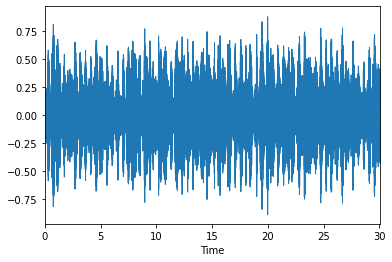

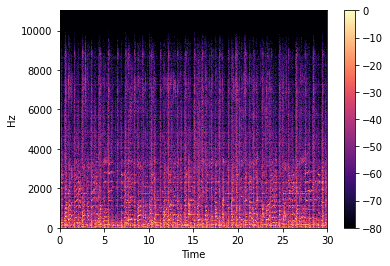

In [5]:
# Testing the sample
y, sr, label = gtzan[0]
print("Example of data with a waveform {}, a sample rate of {} and a label of {}".format(y.shape,sr,label))

y = np.array(y[0]) # To work with librosa
plt.figure()
librosa.display.waveplot(y,sr)
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure()
librosa.display.specshow(S_db, x_axis='time', y_axis='linear')
plt.colorbar()

In [6]:
#--------Normalize-----------
"""
def get_mu_std_quick(dataset):
    ######################################
    # START code block: write code below
    ######################################
    sample = np.array(dataset[0][0][0]) 
    for i in range(1,len(dataset)) :
      sample = np.append(sample,np.array(dataset[i][0][0]))
    mu = np.mean(sample)
    std = np.std(sample)
    ######################################
    # END code block
    ######################################
    return mu, std

mu, std = get_mu_std_quick(gtzan_train)
print(f'Statistics per channel: mu={mu}, std={std}')
"""

#-----------Resize-----------
"""
all_length = np.array([len(gtzan[i][0][0]) for i in range(len(gtzan_train))])
lenght_min = np.min(all_length)
print(lenght_min)
"""

'\nall_length = np.array([len(gtzan[i][0][0]) for i in range(len(gtzan_train))])\nlenght_min = np.min(all_length)\nprint(lenght_min)\n'

In [7]:
# Mean and variance which were computed
mu, std = -0.0010253926739096642, 0.15775565803050995
length_min = 660000

In [8]:
# Necessary because tensors don't have the same lengh
def resize(tensor, random=False):
  if (random):
    mask = torch.ones(tensor.numel(), dtype=torch.bool)
    indices = np.arange(tensor.numel())
    np.random.shuffle(indices)
    indices = indices[:tensor.numel()-lenght_min]
    mask[indices] = False
    return tensor[mask]
  else:
    return tensor[:length_min]



In [9]:
# Very simple class to work with our dataset
class MusicDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)



In [10]:
#-----------------Loading Datasets------------------
dataset = []
segment = length_min
batch_size = 10
print_every = 20

for music in gtzan:
  dataset += [(torch.stack([(resize(music[0][0])-mu)/(std**2)]), Genres[music[2]])]


In [11]:
Musics = MusicDataset(dataset)
loader_train = DataLoader(Musics, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(range(440)))
loader_val = DataLoader(Musics, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(range(440,640)))
loader_test = DataLoader(Musics, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(range(660,1000)))

In [12]:
len(loader_val.dataset)

1000

In [26]:
#-----------------Loading Datasets------------------
dataset_train = []
dataset_val = []
dataset_test = []
segment = length_min
batch_size = 10
print_every = 20

for music in gtzan_train:
  dataset_train += [(torch.stack([(resize(music[0][0])-mu)/(std**2)]), Genres[music[2]])]

for music in gtzan_val:
  dataset_val += [(torch.stack([(resize(music[0][0])-mu)/(std**2)]), Genres[music[2]])]

for music in gtzan_test:
  dataset_test += [(torch.stack([(resize(music[0][0])-mu)/(std**2)]), Genres[music[2]])]

In [24]:

#-----------------Loading Datasets------------------
# We take 3s of each sample to have more data to train on 
dataset_train = []
dataset_val = []
dataset_test = []
segment = length_min//10
batch_size = 64
print_every = 20

for music in gtzan_train:
  resized = (resize(music[0][0])-mu)/(std**2)
  audio_cut = [resized[i*segment:(i+1)*segment] for i in range(10)]
  for audio in audio_cut:
    dataset_train += [(torch.stack([audio]), Genres[music[2]])]

for music in gtzan_val:
  resized = (resize(music[0][0])-mu)/(std**2)
  audio_cut = [resized[i*segment:(i+1)*segment] for i in range(10)]
  for audio in audio_cut:
    dataset_val += [(torch.stack([audio]), Genres[music[2]])]

for music in gtzan_test:
  resized = (resize(music[0][0])-mu)/(std**2)
  audio_cut = [resized[i*segment:(i+1)*segment] for i in range(10)]
  for audio in audio_cut:
    dataset_test += [(torch.stack([audio]), Genres[music[2]])]



In [27]:
#------Creating Loaders----------
Musics_train = MusicDataset(dataset_train)
loader_train = DataLoader(Musics_train, batch_size=batch_size)

Musics_val = MusicDataset(dataset_val)
loader_val = DataLoader(Musics_val, batch_size=batch_size)

Musics_test = MusicDataset(dataset_test)
loader_test = DataLoader(Musics_test, batch_size=batch_size)

In [28]:
len(loader_train.dataset)

443

In [17]:
def flatten(x):
    N = x.shape[0] 
    return x.view(N, -1) 

# Creation of models

In [18]:
def check_accuracy(loader, model):
    print("Checking accuracy") 
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  
            y = y.to(device=device, dtype=torch.long)

            scores = model.forward(x)
            prediction = torch.max(scores,1).indices
            num_samples += x.shape[0]
            num_correct += sum(prediction==y)

        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [19]:
def run_val(loader, model):
    model.eval()
    loss = None
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype) 
            y = y.to(device=device, dtype=torch.long)

            scores = model.forward(x)
            if (loss):
              loss += F.cross_entropy(scores,y).to(device=device)
            else : 
              loss = F.cross_entropy(scores,y).to(device=device)

    return loss

### 4. Training Loop


In [20]:
def train_module(model, optimizer, epochs=1):
    losses = {}
    losses_val = {}
    model = model.to(device=device) 
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                losses[e * len(loader_train) + t] = loss.item()
                check_accuracy(loader_val, model)
                print()
        
        loss_val = run_val(loader_val, model)
        losses_val[(e + 1) * len(loader_train)] = loss_val.item()

    return losses, losses_val

# Part IV. PyTorch Sequential API


In [29]:
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

learning_rate = 0.001

model = nn.Sequential(
    Flatten(),
    nn.Linear(segment,512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512,256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(64,10),  
)

optimizer = optim.Adam(model.parameters(),lr=learning_rate)

_ = train_module(model, optimizer, epochs=3)

Iteration 0, loss = 2.2613
Checking accuracy
Got 23 / 197 correct (11.68)

Iteration 20, loss = 9.7579
Checking accuracy
Got 22 / 197 correct (11.17)

Iteration 40, loss = 3.9026
Checking accuracy
Got 11 / 197 correct (5.58)

Iteration 0, loss = 64.3667
Checking accuracy
Got 17 / 197 correct (8.63)

Iteration 20, loss = 21.6154
Checking accuracy
Got 26 / 197 correct (13.20)

Iteration 40, loss = 12.0306
Checking accuracy
Got 20 / 197 correct (10.15)

Iteration 0, loss = 41.9825
Checking accuracy
Got 18 / 197 correct (9.14)

Iteration 20, loss = 9.2098
Checking accuracy
Got 28 / 197 correct (14.21)

Iteration 40, loss = 8.7790
Checking accuracy
Got 29 / 197 correct (14.72)



### 2. Three-Layer ConvNet


In [ ]:
channel_1 = 32
channel_2 = 16
learning_rate = 1e-2

model = None
optimizer = None

################################################################################
# TODO: Rewrite the 3-layer ConvNet with bias from Part III with the           #
# Sequential API.                                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

model = nn.Sequential(
    nn.Conv1d(1,channel_1,5,padding=2),
    nn.ReLU(),
    nn.Conv1d(channel_1,channel_2,3,padding=1),
    nn.ReLU(),
    Flatten(),
    nn.Linear(channel_2*segment,10),
)
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             
################################################################################

losses = train_module(model, optimizer, epochs=3)

Iteration 0, loss = 2.2665
Checking accuracy on validation set
Got 46 / 443 correct (10.38)

Iteration 0, loss = 2.4450
Checking accuracy on validation set
Got 47 / 443 correct (10.61)

Iteration 0, loss = 2.4269
Checking accuracy on validation set
Got 47 / 443 correct (10.61)



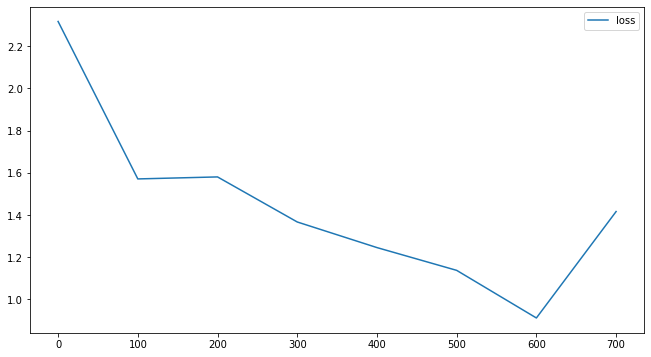

In [ ]:
fig, ax = plt.subplots(figsize=(11, 6))
x = sorted(losses[0].keys())
y = [losses[0][e] for e in x]
ax.plot(x, y, label='loss')
ax.legend()

# Final


In [ ]:
################################################################################
# TODO:                                                                        #         
# Experiment with any architectures, optimizers, and hyperparameters.          #
# Achieve AT LEAST 70% accuracy on the *validation set* within 10 epochs.      #
#                                                                              #
# Note that you can use the check_accuracy function to evaluate on either      #
# the test set or the validation set, by passing either loader_test or         #
# loader_val as the second argument to check_accuracy. You should not touch    #
# the test set until you have finished your architecture and  hyperparameter   #
# tuning, and only run the test set once at the end to report a final value.   #
################################################################################
model = None
optimizer = None

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
channel_1 = 32
channel_2 = 64
channel_3 = 128
model = nn.Sequential(

)

optimizer = optim.RMSprop(model.parameters(),lr=1e-2)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             
################################################################################

# You should get at least 70% accuracy
losses = train_module(model, optimizer, epochs=10)
fig, ax = plt.subplots(figsize=(11, 6))
x = sorted(losses[0].keys())
y = [losses[0][e] for e in x]
ax.plot(x, y, label='loss')
ax.legend()

NameError: ignored

In [ ]:
best_model = model
check_accuracy(loader_test, best_model)

NameError: ignored